In [121]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras


In [122]:
#fds.list_builders()

In [273]:
ds = 'malaria'
builder = tfds.builder(ds)
info = builder.info
info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images
    with equal instances of parasitized and uninfected cells from the thin blood 
    smear slide images of segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='C:\\Users\\edmun\\tensorflow_datasets\\malaria\\1.0.0',
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear image

## Loading the data

In [371]:

ds_all, ds_all_info = tfds.load(name='malaria', split="train", shuffle_files=True, with_info=True)

train_ds, val_ds, test_ds = tfds.load(ds, split=['train[:1%]', 'train[70%:85%]', 'train[85%:]'])


In [372]:
print("Number of prediction classes:", ds_all_info.features['label'].num_classes)
print("Prediction classes:", ds_all_info.features['label'].names)

Number of prediction classes: 2
Prediction classes: ['parasitized', 'uninfected']


In [373]:
no_train = tf.data.experimental.cardinality(train_ds).numpy()
no_valid = tf.data.experimental.cardinality(val_ds).numpy()
no_test = tf.data.experimental.cardinality(test_ds).numpy()

In [374]:
print("Number of training images:", no_train)
print("Number of validating images:", no_valid)
print("Number of testing images:", no_test)

Number of training images: 276
Number of validating images: 4133
Number of testing images: 4134


## Showing Examples

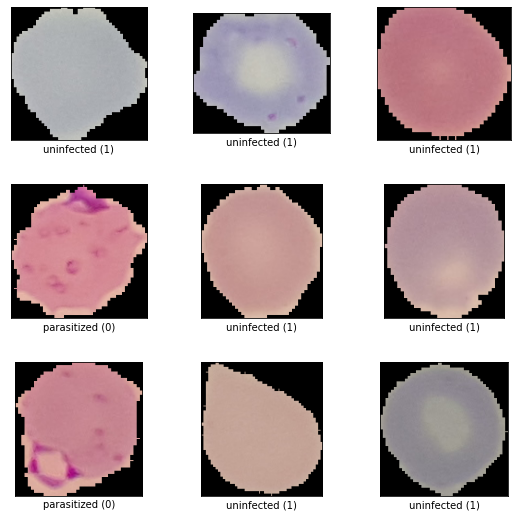

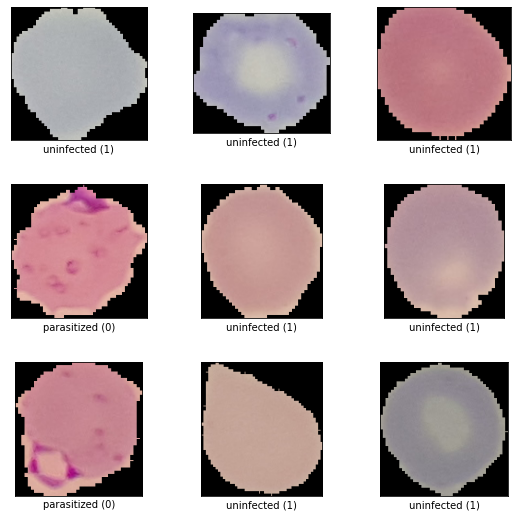

In [375]:
tfds.show_examples(ds_all, info)

## Data Preparation   

Extracting the images

In [380]:
train_images = np.array([example['image'].numpy() for example in train_ds] , dtype="object")
train_labels = [example['label'] for example in train_ds]

In [349]:
# val_images = np.array([example['image'].numpy() for example in val_ds], dtype="object")
# val_labels = np.array([example['label'].numpy() for example in val_ds], dtype="object")

# test_images = np.array([example['image'].numpy() for example in test_ds], dtype="object")
# test_labels = np.array([example['label'].numpy() for example in test_ds], dtype="object")

Checking to see the consistency in image lengths. 


In [385]:
for i in train_images:
    print(i.shape)

(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 

The images are of different lengths. We need to pad/crop the images to achieve images of same lengths.

In [384]:
for i in range(len(train_images)):
    train_images[i] = tf.image.resize_with_crop_or_pad(train_images[i], 200, 200)
    train_images[i] = tf.image.convert_image_dtype(train_images[i], tf.float64)
    train_images[i] = tf.reshape(train_images[i], [200,200,3])


In [386]:
type(train_images)

numpy.ndarray

In [388]:
train_images[:2]

array([<tf.Tensor: shape=(200, 200, 3), dtype=float64, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])>,
       <tf.Tensor: shape=(200, 200, 3), d

In [402]:
new_train_images = tf.constant(tf.stack([i.numpy() for i in train_images])).numpy()


In [ ]:
train

In [ ]:
new_train_labels

In [404]:
new_train_images

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [353]:
# for i in range(len(val_images)):
#     val_images[i] = tf.image.resize_with_crop_or_pad(val_images[i], 200, 200)
#     val_images[i] = tf.image.convert_image_dtype(val_images[i], tf.float32)

In [354]:
# for i in range(len(test_images)):
#     test_images[i] = tf.image.resize_with_crop_or_pad(test_images[i], 200, 200)
#     test_images[i] = tf.image.convert_image_dtype(test_images[i], tf.float32)

In [355]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")

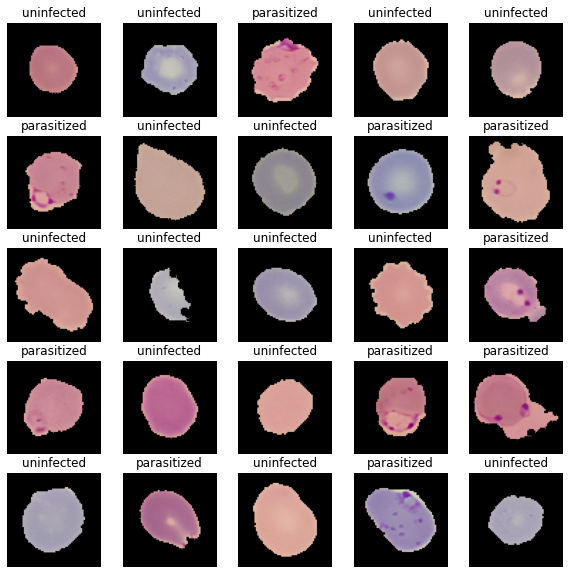

In [356]:
show_batch(train_images, train_labels)

## Model Building

In [357]:
# train_images=train_images.tolist()

In [363]:
for i in range(len(train_images)):
    train_images[i] = train_images[i].numpy().tolist()

In [366]:
train_images

KeyboardInterrupt: 

In [358]:
model = keras.Sequential([
  keras.layers.Flatten(),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(2, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images,train_labels, epochs=5, batch_size=32)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type tensorflow.python.framework.ops.EagerTensor).

tensor( <shape(3,1)>
    tensor( <shape(1,3)> ),
    tensor( <shape(1,3)> ),
    tensor( <shape(1,3)> ),
)

conver to 

tensor( <shape(3,3)> )